# Prototype hybrid matrix factorization model for drug reccomendations using PyTorch

## Setup and data load

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F

from sklearn import metrics

Data load

In [2]:
# Drug sensitivity values from GDSC v2
filepath = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Sensitivity profiles/v17.3_fitted_dose_response-March_27th_2018.xlsx"

drug_response_df = pd.read_excel(filepath)
print(drug_response_df.shape)
drug_response_df.head(3)

(224202, 13)


,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170


In [3]:
# Full gene expression data
filepath = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Gene expression/sanger1018_brainarray_ensemblgene_rma-March_2nd_2017.txt"
gene_expression_df = pd.read_table(filepath)
print(gene_expression_df.shape)
gene_expression_df.head(3)

(17737, 1019)


,ensembl_gene,906826,687983,910927,1240138,1240139,906792,910688,1240135,1290812,...,753584,907044,998184,908145,1659787,1298157,1480372,1298533,930299,905954.1
0,ENSG00000000003,7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,5.943046,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,ENSG00000000005,2.964585,2.777716,2.643508,2.817923,2.957739,2.889677,2.828203,2.874751,2.686874,...,2.798847,2.745137,2.976406,2.852552,2.622630,2.639276,2.879890,2.521169,2.870468,2.834285
2,ENSG00000000419,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987,10.264385,10.205931,10.299757,...,10.486486,10.442951,10.311962,10.454830,10.418475,11.463742,10.557777,10.792750,9.873902,10.788218


## Model prototyping
Try to build simple linear model with fake data

#### Model definition

In [4]:
# class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
#     def __init__(self, cell_line_input_dim, drug_input_dim, output_dim):
#         super(LinearMatrixFactorizationWithFeatures, self).__init__()
#         self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim)
#         self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim)
        
#     def forward(self, drug_features, cell_line_features):
#         drug_outputs = self.drug_linear(drug_features)
#         cell_line_outputs = self.cell_line_linear(cell_line_features)
        
#         final_outputs = torch.mm(drug_outputs, cell_line_outputs.t())
#         return final_outputs
    
#     def cl_outputs(self, cell_line_features):
#         cell_line_outputs = self.cell_line_linear(cell_line_features)
#         return cell_line_outputs
#     def drug_outputs(self, drug_features):
#         drug_outputs = self.drug_linear(drug_features)
#         return drug_outputs

class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, cell_line_input_dim, drug_input_dim, output_dim):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim)
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim)
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.zeros(drug_outputs.shape[0])
        for k in range(drug_outputs.shape[1]):
            final_outputs = final_outputs + drug_outputs[:, k] * cell_line_outputs[:, k]
            
        # final_outputs = cell_line_outputs[:, 0]
        return final_outputs
    
    def cl_outputs(self, cell_line_features):
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        return cell_line_outputs
    def drug_outputs(self, drug_features):
        drug_outputs = self.drug_linear(drug_features)
        return drug_outputs

#### Dummy data without relationships (just to check if model does forward pass)

In [5]:
# Create random "cell line" data
cell_line_data = np.random.uniform(0.0001, 3., size=(1000, 10))

# Create random "drug" data
N = 200 * 5
K = 50   # How many ones

drug_data = np.array([1] * K + [0] * (N-K))
np.random.shuffle(drug_data)
drug_data = drug_data.reshape(200, -1)
# Make sure that every row in drug_data has at least one one
for i in range(drug_data.shape[0]):
    if drug_data[i].sum() == 0:
        drug_data[i, np.random.randint(drug_data.shape[1])] = 1

print(cell_line_data.shape, drug_data.shape)

(1000, 10) (200, 5)


In [6]:
# Instantiate the model
cell_line_dim = 10
drug_dim = 5
output_dim = 2

model = LinearMatrixFactorizationWithFeatures(cell_line_dim, drug_dim, output_dim)
# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (cell_line_linear): Linear(in_features=10, out_features=2, bias=True)
  (drug_linear): Linear(in_features=5, out_features=2, bias=True)
)

In [7]:
# Print info about model parameters
s = 0
for param in model.parameters():
    print(param.shape)
    s += 1
print()
print("Number of parameters (tensors):", s)

torch.Size([2, 10])
torch.Size([2])
torch.Size([2, 5])
torch.Size([2])

Number of parameters (tensors): 4


In [8]:
# Compute inputs for the model
cell_line_input = Variable(torch.from_numpy(cell_line_data))
drug_input = Variable(torch.from_numpy(drug_data))
print(cell_line_input.dtype, drug_input.dtype)

torch.float64 torch.int64


In [9]:
# Test forward passes for cell lines and drugs
cl_outputs = model.cl_outputs(cell_line_input.float()[:16])
drug_outputs = model.drug_outputs(drug_input.float()[:16])

In [10]:
print(cl_outputs.shape, cl_outputs.dtype)
print(drug_outputs.shape, drug_outputs.dtype)

torch.Size([16, 2]) torch.float32
torch.Size([16, 2]) torch.float32


In [11]:
A = cl_outputs[:10]
B = drug_outputs[:5]
print(A.shape, B.shape)

torch.Size([10, 2]) torch.Size([5, 2])


In [12]:
# Check out dot products and matrix multiplication of two vectors
print(A[0])
print(B[0])
print(torch.dot(A[0], B[0]), torch.dot(A[0], B[0]).item())
print(torch.mm(A[0].view(2, 1).t(), B[0].view(2, 1)),
     torch.mm(A[0].view(2, 1).t(), B[0].view(2, 1)).item())

tensor([-0.2532,  0.3023], grad_fn=<SelectBackward>)
tensor([0.1349, 0.0666], grad_fn=<SelectBackward>)
tensor(-0.0140, grad_fn=<DotBackward>) -0.014005105942487717
tensor([[-0.0140]], grad_fn=<MmBackward>) -0.014005105942487717


In [13]:
# Check out matrix multiplication
print(A.shape, B.shape)
print(torch.mm(B, A.t()).shape)
print(torch.mm(B, A.t()))

torch.Size([10, 2]) torch.Size([5, 2])
torch.Size([5, 10])
tensor([[-0.0140,  0.0341, -0.2181, -0.0821, -0.0998,  0.1758, -0.1272,  0.0640,
         -0.0053, -0.1006],
        [-0.0140,  0.0341, -0.2181, -0.0821, -0.0998,  0.1758, -0.1272,  0.0640,
         -0.0053, -0.1006],
        [ 0.0913,  0.1727, -0.1863, -0.0294, -0.0888,  0.2594,  0.1641,  0.1455,
          0.2507,  0.1431],
        [ 0.0913,  0.1727, -0.1863, -0.0294, -0.0888,  0.2594,  0.1641,  0.1455,
          0.2507,  0.1431],
        [-0.0140,  0.0341, -0.2181, -0.0821, -0.0998,  0.1758, -0.1272,  0.0640,
         -0.0053, -0.1006]], grad_fn=<MmBackward>)


In [14]:
# Check if entries in above matrix corresponds to dot products of corresponding cell line and
# drug latent representations
cl_idx = 2
dr_idx = 4
print(A[cl_idx], B[dr_idx])
print(torch.dot(A[cl_idx], B[dr_idx]).item())
print(torch.mm(B, A.t())[dr_idx, cl_idx].item())

tensor([-1.2043, -0.8345], grad_fn=<SelectBackward>) tensor([0.1349, 0.0666], grad_fn=<SelectBackward>)
-0.21805094182491302
-0.21805094182491302


In [15]:
# Check out if model does final forward passing
drug_input = Variable(torch.from_numpy(drug_data)[:4])
cell_line_input = Variable(torch.from_numpy(cell_line_data)[:4])
print(drug_input.shape, cell_line_input.shape)

sample_output = model(drug_input.float(), cell_line_input.float())
print(sample_output.shape)

torch.Size([4, 5]) torch.Size([4, 10])
torch.Size([4])


In [16]:
sample_output

tensor([-0.0140,  0.0341, -0.1863, -0.0294], grad_fn=<AddBackward0>)

#### Try to train the model on dummy data

In [17]:
# Generate dummy data
cell_line_data = np.random.uniform(0.0001, 3., size=(10, 2))
drug_data = np.random.random(size=(10, 2))

A = np.array([[2, 3],
             [1, 1]])
cell_line_outputs = cell_line_data @ A
drug_outputs = drug_data @ A

print(drug_outputs.shape, cell_line_outputs.shape)

final_output = drug_outputs @ cell_line_outputs.T

(10, 2) (10, 2)


In [18]:
# Create response data
ys = []
drug_ids = []
cell_line_ids = []
for drug in range(final_output.shape[0]):
    for cl in range(final_output.shape[1]):
        drug_ids.append(drug)
        cell_line_ids.append(cl)
        ys.append(final_output[drug, cl])
        
response_df = pd.DataFrame({"drug_id": drug_ids,
                           "cell_line_id": cell_line_ids,
                           "AUC": ys})
print(response_df.shape)
response_df.sample(3)

(100, 3)


,drug_id,cell_line_id,AUC
65,6,5,41.649413
35,3,5,46.334148
89,8,9,18.680281


In [19]:
drug_output = drug_data[3:4] @ A
cl_output = cell_line_data[2:3] @ A
print(drug_output @ cl_output.T)

[[20.82548137]]


In [20]:
# Specify hyperparameters
drug_dim = 2
cell_line_dim = 2
output_dim = 2


learning_rate = 0.001
epochs = 100
output_dim = 2
batch_size = 8
no_batches = response_df.shape[0] // batch_size

model = LinearMatrixFactorizationWithFeatures(cell_line_dim, drug_dim, output_dim)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (cell_line_linear): Linear(in_features=2, out_features=2, bias=True)
  (drug_linear): Linear(in_features=2, out_features=2, bias=True)
)

In [21]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1687, -0.3713],
        [ 0.2256, -0.5032]], requires_grad=True)
Parameter containing:
tensor([ 0.2329, -0.5745], requires_grad=True)
Parameter containing:
tensor([[-0.4617, -0.2961],
        [ 0.1023,  0.6634]], requires_grad=True)
Parameter containing:
tensor([-0.5961,  0.1589], requires_grad=True)


In [22]:
# Training the model
for epoch in range(epochs):
    for batch in range(no_batches):
        # Separate response variable batch
        response_batch = response_df.iloc[batch * batch_size:(batch + 1) * batch_size]
        
        # Extract output variable batch
        y_batch = Variable(torch.from_numpy(response_batch["AUC"].values))
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = response_batch["cell_line_id"].values
        # Extract corresponding cell line data
        cell_line_input_batch = Variable(torch.from_numpy(cell_line_data[cl_ids]))
        
        # Extract drug IDs for which data shall be extracted
        drug_ids = response_batch["drug_id"].values
        # Extract corresponding drug data
        drug_input_batch = Variable(torch.from_numpy(drug_data[drug_ids]))
        
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, 
        # dont want to cummulate gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        batch_output = model(drug_input_batch.float(), cell_line_input_batch.float())
        # Compute the loss for this batch
        loss = criterion(batch_output, y_batch.float())
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
    print("Epoch {}, loss: {:.3f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 118.536
Epoch 2, loss: 2.768
Epoch 3, loss: 2.241
Epoch 4, loss: 1.723
Epoch 5, loss: 1.346
Epoch 6, loss: 1.080
Epoch 7, loss: 0.897
Epoch 8, loss: 0.777
Epoch 9, loss: 0.704
Epoch 10, loss: 0.664
Epoch 11, loss: 0.647
Epoch 12, loss: 0.645
Epoch 13, loss: 0.651
Epoch 14, loss: 0.661
Epoch 15, loss: 0.670
Epoch 16, loss: 0.675
Epoch 17, loss: 0.676
Epoch 18, loss: 0.671
Epoch 19, loss: 0.660
Epoch 20, loss: 0.643
Epoch 21, loss: 0.622
Epoch 22, loss: 0.595
Epoch 23, loss: 0.566
Epoch 24, loss: 0.534
Epoch 25, loss: 0.501
Epoch 26, loss: 0.467
Epoch 27, loss: 0.433
Epoch 28, loss: 0.399
Epoch 29, loss: 0.367
Epoch 30, loss: 0.337
Epoch 31, loss: 0.308
Epoch 32, loss: 0.281
Epoch 33, loss: 0.256
Epoch 34, loss: 0.233
Epoch 35, loss: 0.213
Epoch 36, loss: 0.194
Epoch 37, loss: 0.176
Epoch 38, loss: 0.161
Epoch 39, loss: 0.147
Epoch 40, loss: 0.134
Epoch 41, loss: 0.123
Epoch 42, loss: 0.113
Epoch 43, loss: 0.104
Epoch 44, loss: 0.095
Epoch 45, loss: 0.088
Epoch 46, loss: 0

In [23]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-3.2435, -1.5444],
        [ 1.3535, -0.0942]], requires_grad=True)
Parameter containing:
tensor([-0.2629, -0.4530], requires_grad=True)
Parameter containing:
tensor([[-3.4650, -1.2164],
        [ 0.9629,  0.9375]], requires_grad=True)
Parameter containing:
tensor([0.0326, 0.1548], requires_grad=True)


In [24]:
response_df.sample(2)

,drug_id,cell_line_id,AUC
80,8,0,29.180183
57,5,7,13.046979


In [25]:
# Testing
with torch.no_grad(): # We don't need gradients in the testing phase
    prediction = model(Variable(torch.from_numpy(drug_data[0:1])).float(), 
                       Variable(torch.from_numpy(cell_line_data[0:1])).float())
print(prediction)

tensor([39.4780])


## Model prototyping on GDSCv2 data
Try to run the model on real data

#### Classes and model definition

In [4]:
# Classes and functions for data extraction
class CellLine(object):
    """Basic, parent class representing cell line regradless of data source"""
    def __init__(self, cell_line_name, cell_line_id, data_source):
        self.name = cell_line_name
        self.id = cell_line_id
        self.data_source = data_source

class Drug(object):
    def __init__(self, drug_name, drug_id, data_source):
        self.name = drug_name
        self.id = drug_id
        self.data_source = data_source
        
class CellLineGDSCv2(CellLine):
    """Class representing single cell line in GDSCv2"""
    def __init__(self, cell_line_name, cell_line_id):
        super().__init__(cell_line_name, cell_line_id, "GDSCv2")
    def extract_full_gene_expression_data(self, gene_expression_df):
        """Extract gene expressions of all available genes"""
        # Just extract column corresponding to the cell line COSMIC ID
        if str(self.id) in gene_expression_df.columns:
            return gene_expression_df[str(self.id)]
        else:
            raise KeyError("Cell line ID not present in gene expression data")
            
class DrugGDSCv2(Drug):
    """Class representing single drug in GDSCv2"""
    def __init__(self, drug_name, drug_id, targets):
        super().__init__(drug_name, drug_id, "GDSCv2")
        self.targets = targets
        
    def extract_binary_targets_vector(self, drug_response_df):
        """Extract binary targets vector using just data from GDSCv2, meaning sparse vector of 
        length [all unique putative targets of GDSCv2 drugs] where 1 indicates presence of a 
        given gene target
        """
        all_targets = []
        for targets in drug_response_df["PUTATIVE_TARGET"].unique():
            all_targets = all_targets + targets.split(", ")
        all_targets = set(all_targets)
        return [1 if x in self.targets else 0 for x in all_targets]
    
class CellLinesDataGDSCv2(object):
    @staticmethod
    def extract_full_gene_expresson_data(gene_expression_df):
        df = gene_expression_df.transpose()
        df.columns = df.loc["ensembl_gene"].values
        df = df.drop("ensembl_gene")
        df.insert(0, "cosmic_id", df.index)
        # Drop cell lines with strange IDs
        df = df.drop(["1503362.1", "1330983.1", "909976.1", "905954.1"])
        df.index = df.index.map(int)
        return df.apply(pd.to_numeric)


class DrugsDataGDSCv2(object):
    @staticmethod
    def extract_binary_targets_vectors(drug_response_df, drug_list=None):
        """Extract binary targets vectors for all specified drugs using just data from GDSCv2, meaning 
        sparse vectors of length [all unique putative targets of specified drugs] where 1 indicates presence 
        of a given gene target."""
        # Compute the set of all considered targets
        all_targets = []
        if drug_list:
            for targets in drug_response_df[
                drug_response_df["DRUG_ID"].isin(drug_list)]["PUTATIVE_TARGET"].unique():
                all_targets = all_targets + targets.split(", ")
        else:
            for targets in drug_response_df["PUTATIVE_TARGET"].unique():
                all_targets = all_targets + targets.split(", ")
        all_targets = list(set(all_targets))
        
        # Initialize DataFrame containing binary vectors for drugs
        columns=["drug_id", "drug_name"] + all_targets
        df = pd.DataFrame(columns=columns)
        # Now iterate over drugs and create binary target vector for each of them
        if drug_list:
            for drug_id in drug_list:
                drug_name = drug_response_df[
                    drug_response_df["DRUG_ID"] == drug_id]["DRUG_NAME"].iloc[0]
                drug_targets = drug_response_df[
                    drug_response_df["DRUG_ID"] == drug_id]["PUTATIVE_TARGET"].iloc[0].split(", ")
                # Create binary target vector for this drug
                binary_targets = [1 if x in drug_targets else 0 for x in all_targets]
                row = pd.Series([drug_id, drug_name] + binary_targets, index=columns)
                df = df.append(row, ignore_index=True)
        else:
            for drug_id in drug_response_df["DRUG_ID"].unique():
                drug_name = drug_response_df[
                    drug_response_df["DRUG_ID"] == drug_id]["DRUG_NAME"].iloc[0]
                drug_targets = drug_response_df[
                    drug_response_df["DRUG_ID"] == drug_id]["PUTATIVE_TARGET"].iloc[0].split(", ")
                # Create binary target vector for this drug
                binary_targets = [1 if x in drug_targets else 0 for x in all_targets]
                row = pd.Series([drug_id, drug_name] + binary_targets, index=columns)
                df = df.append(row, ignore_index=True)
        df.index = df["drug_id"]
        df[df.columns[2:]] = df[df.columns[2:]].apply(pd.to_numeric)
        df["drug_id"] = df["drug_id"].astype(int)
        return df
    
def evaluate_predictions(y_true, preds):
    """Compute RMSE and correlation with true values for model predictions"""
    print("RMSE:", metrics.mean_squared_error(y_true, preds) ** 0.5)
    print("Correlation:", pearsonr(y_true, preds))

In [5]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.zeros(drug_outputs.shape[0])
        for k in range(drug_outputs.shape[1]):
            final_outputs = final_outputs + drug_outputs[:, k] * cell_line_outputs[:, k]
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs

#### Try to train the model on real data

Compute cell line and drug features (gene expression and binary targets vectors) and response variable

In [6]:
# Compute cell line and drug features (gene expression and binary targets vectors)
# Cell line data
cell_line_data_df = CellLinesDataGDSCv2.extract_full_gene_expresson_data(gene_expression_df)
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(1014, 17738)


,cosmic_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000264575,ENSG00000265060,ENSG00000265246,ENSG00000265298,ENSG00000265480,ENSG00000265929,ENSG00000266066,ENSG00000266282,ENSG00000266433,ENSG00000266753
906826,906826,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,...,6.786925,2.997054,3.109774,7.882377,3.331134,2.852537,3.130696,9.986616,3.073724,7.284733
687983,687983,7.548671,2.777716,11.807341,4.066887,3.732485,3.152404,7.827172,6.616972,5.809264,...,5.317911,3.263745,3.059424,8.681302,2.992611,2.776771,3.260982,9.002814,3.000182,8.504804
910927,910927,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,...,3.143006,3.112145,2.930254,8.707886,2.886574,2.685307,3.176239,9.113243,2.916274,7.059092


In [7]:
# Drug data
drug_data_df = DrugsDataGDSCv2.extract_binary_targets_vectors(drug_response_df)
print(drug_data_df.shape)
drug_data_df.head(3)

(266, 240)


,drug_id,drug_name,TRCB,others,AKT2,not defined,PARP2,ABL(T315I),EPHB4,BCL2,...,"TIE2,AXL",MAP4K2,BRD2,JNK,RAF,Dihydrofolate reductase (DHFR),CDK4,TRAIL receptor agonist,ROCK,dsDNA break induction
drug_id,,,,,,,,,,,,,,,,,,,,,
1,1,Erlotinib,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Rapamycin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,Sunitinib,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Response variable DataFrame
response_df = drug_response_df[["DRUG_ID", "COSMIC_ID", "AUC"]].sample(
    frac=1, random_state=11).reset_index(drop=True)
print(response_df.shape)
response_df.head(3)

(224202, 3)


,DRUG_ID,COSMIC_ID,AUC
0,194,906765,0.569102
1,219,684681,0.621944
2,269,908142,0.785489


In [9]:
# Extract only data for which we have cell line and drug features
common_cell_lines = set(cell_line_data_df.index).intersection(set(response_df["COSMIC_ID"]))
cell_line_data = cell_line_data_df.loc[common_cell_lines]
response_df = response_df[response_df.COSMIC_ID.isin(common_cell_lines)]
print(len(common_cell_lines), cell_line_data.shape, response_df.shape)

983 (983, 17738) (213354, 3)


In [10]:
# Extract data for common drugs
common_drugs = set(drug_data_df.index).intersection(set(response_df.DRUG_ID))
drug_data = drug_data_df.loc[common_drugs]
response_df = response_df[response_df.DRUG_ID.isin(common_drugs)]
print(len(common_drugs), drug_data.shape, response_df.shape, response_df["AUC"].std())

266 (266, 240) (213354, 3) 0.1946543172583224


In [11]:
# Take a sample of the data for testing
# response_df = response_df.iloc[:10000]
# print(response_df["AUC"].std())

In [12]:
# # Split the data into train, validation and test, without separating any cell lines
# test_ratio = 0.3
# val_number = 20000

# # Split into train/test set
# train_samples = response_df[int(test_ratio * response_df.shape[0]):]
# test_samples = response_df[:int(test_ratio * response_df.shape[0])]

# # Split test set into validation/held-out test
# val_samples = test_samples[-val_number:]
# test_samples = test_samples[:-val_number]
# print(train_samples.shape, val_samples.shape, test_samples.shape)

In [13]:
# Split the data into train, validation and test, with some spearate cell lines between training and 
# validation set
n_test_cls = 20   # Number of cell lines to separate

test_ratio = 0.20
val_number = 20000
# First extract random sample of separate cell lines for validation only
test_cell_lines = np.random.choice(response_df["COSMIC_ID"].unique(), size=n_test_cls, replace=False)

# Remove pairs with these cell lines from the rest of the data
train_samples = response_df[~response_df["COSMIC_ID"].isin(test_cell_lines)]
print(train_samples["COSMIC_ID"].nunique(), len(test_cell_lines), response_df["COSMIC_ID"].nunique())

# Check if two sets of cell lines are disjoint
assert len(set(train_samples["COSMIC_ID"]).intersection(set(test_cell_lines))) == 0

# Extract validation sets without separate cell lines
test_samples = train_samples[:int(test_ratio * response_df.shape[0])]
train_samples = train_samples[int(test_ratio * response_df.shape[0]):]

# Split test set into validation/held-out test
val_samples = test_samples[-val_number:]
test_samples = test_samples[:-val_number]

# Extract separate test cell lines samples
separate_cell_lines_samples = response_df[response_df["COSMIC_ID"].isin(test_cell_lines)]

# Check if all datasets are complementary
common_cell_lines = set(train_samples["COSMIC_ID"])
for dataset in [train_samples, val_samples, test_samples, separate_cell_lines_samples]:
    common_cell_lines = common_cell_lines.intersection(set(dataset["COSMIC_ID"]))
    
assert len(common_cell_lines) == 0

print(train_samples.shape, val_samples.shape, test_samples.shape,
     separate_cell_lines_samples.shape, response_df.shape)

963 20 983
(166224, 3) (20000, 3) (22670, 3) (4460, 3) (213354, 3)


In [14]:
# Remove identifiers (not features) from drug and cell line data
cell_line_data = cell_line_data.drop("cosmic_id", axis=1)
drug_data = drug_data.drop(["drug_id", "drug_name"], axis=1)
print(cell_line_data.shape, drug_data.shape)

(983, 17737) (266, 238)


In [15]:
# Normalize cell line input data
# Compute data mean and std for cell lines in the trainig set
expression_mean = cell_line_data.mean()
expression_std = cell_line_data.std()

cell_line_data = (cell_line_data - expression_mean) / expression_std
print(cell_line_data.sum().sum(), cell_line_data.std().sum())

1.9566095327326703e-10 17737.0


In [16]:
response_df.shape

(213354, 3)

In [17]:
train_samples["AUC"].iloc[127:147].sum()

18.104856

In [28]:
# Specify hyperparameters
drug_dim = drug_data.shape[1]
cell_line_dim = cell_line_data.shape[1]


learning_rate = 0.00015
epochs = 30
output_dim = 10
batch_size = 128
no_batches = train_samples.shape[0] // batch_size

model = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=238, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=17737, out_features=10, bias=True)
)

In [29]:
# Check out the shapes of the model's parameters 
for p in model.parameters():
    print(p.shape)

torch.Size([10, 238])
torch.Size([10])
torch.Size([10, 17737])
torch.Size([10])


In [30]:
# # Predict on a bigger sample of trainig data
# sample = train_samples.iloc[:val_samples.shape[0]]
# y_true = sample["AUC"].values

# # Create baseline predictions(mean AUC)
# mean_preds = np.array([sample["AUC"].mean()] * sample.shape[0]) + \
#              np.random.normal(loc=0, scale=0.01, size=sample.shape[0])

# cl_input = cell_line_data.loc[sample["COSMIC_ID"].values].values
# drug_input = drug_data.loc[sample["DRUG_ID"].values].values

# model.eval()
# with torch.no_grad():
#     predicted = model(torch.from_numpy(drug_input).float(), 
#                      torch.from_numpy(cl_input).float())
    
# del cl_input, drug_input

# print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
# print("Baseline scores:")
# evaluate_predictions(y_true, mean_preds)
# print()
# print("Model scores:")
# evaluate_predictions(y_true, predicted)

In [31]:
# Training the model
model.train()
for epoch in range(epochs):
    for batch in range(no_batches + 1):
        # Separate response variable batch
        if batch != no_batches:
            samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
        else:
            samples_batch = train_samples.iloc[batch * batch_size:]
            
        # Extract output variable batch
        y_batch = torch.from_numpy(samples_batch["AUC"].values)
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = samples_batch["COSMIC_ID"].values
        # Extract corresponding cell line data
        cell_line_input_batch = cell_line_data.loc[cl_ids].values
        cell_line_input_batch = torch.from_numpy(cell_line_input_batch)
        
        # Extract drug IDs for which data shall be extracted
        drug_ids = samples_batch["DRUG_ID"].values
        # Extract corresponding drug data
        drug_input_batch = drug_data.loc[drug_ids].values
        drug_input_batch = torch.from_numpy(drug_input_batch)
        
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, 
        # dont want to cummulate gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        batch_output = model(drug_input_batch.float(), cell_line_input_batch.float())
        # Compute the loss for this batch
        loss = criterion(batch_output, y_batch.float())
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        #print("Epoch {}, batch {}, loss: {:.3f}".format(epoch + 1, batch + 1, loss.item()))
    # print(cell_line_input_batch[3].sum())
    print("Epoch {}, loss: {:.3f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.055
Epoch 2, loss: 0.040
Epoch 3, loss: 0.033
Epoch 4, loss: 0.031
Epoch 5, loss: 0.030
Epoch 6, loss: 0.029
Epoch 7, loss: 0.016
Epoch 8, loss: 0.016
Epoch 9, loss: 0.015
Epoch 10, loss: 0.014
Epoch 11, loss: 0.013
Epoch 12, loss: 0.013
Epoch 13, loss: 0.012
Epoch 14, loss: 0.012
Epoch 15, loss: 0.012
Epoch 16, loss: 0.012
Epoch 17, loss: 0.011
Epoch 18, loss: 0.011
Epoch 19, loss: 0.011
Epoch 20, loss: 0.011
Epoch 21, loss: 0.011
Epoch 22, loss: 0.011
Epoch 23, loss: 0.011
Epoch 24, loss: 0.011
Epoch 25, loss: 0.011
Epoch 26, loss: 0.011
Epoch 27, loss: 0.011
Epoch 28, loss: 0.011
Epoch 29, loss: 0.011
Epoch 30, loss: 0.011


#### Evaluate on training data

In [22]:
# Do some sample predictions on trainig data
# Sample data points
sample = train_samples.sample(2)
sample

,DRUG_ID,COSMIC_ID,AUC
70241,300,687561,0.946526
134735,1114,687997,0.988758


In [32]:
# Do some predictions on training data
cl_input = cell_line_data.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(drug_input)).float(), 
                     Variable(torch.from_numpy(cl_input)).float())
print(predicted)

tensor([0.5985, 0.9418, 0.9549,  ..., 0.9508, 0.3834, 0.9906])


In [24]:
print(model.drug_linear.weight.shape, model.drug_linear.bias.shape)
print(model.cell_line_linear.weight.shape, model.cell_line_linear.bias.shape)

torch.Size([10, 238]) torch.Size([10])
torch.Size([10, 17737]) torch.Size([10])


In [25]:
# Do predictions manually
drug_out = torch.from_numpy(drug_input[0].reshape(-1, 238)).float() @ model.drug_linear.weight.t() + \
                                                                    model.drug_linear.bias
cl_out = torch.from_numpy(cl_input[0].reshape(-1, 17737)).float() @ model.cell_line_linear.weight.t() + \
                                                            model.cell_line_linear.bias
final_out = torch.zeros(drug_out.shape[0])
for k in range(drug_out.shape[1]):
    final_out = final_out + drug_out[:, k] * cl_out[:, k]
print(final_out.shape, final_out)

torch.Size([1]) tensor([1.5159], grad_fn=<AddBackward0>)


In [33]:
# Predict on a bigger sample of trainig data
sample = train_samples.iloc[:val_samples.shape[0]]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([sample["AUC"].mean()] * sample.shape[0]) + \
             np.random.normal(loc=0, scale=0.01, size=sample.shape[0])

cl_input = cell_line_data.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()
print("Model scores:")
evaluate_predictions(y_true, predicted)

torch.Size([20000]) tensor(1.) tensor(4.1560e-39) tensor(0.8358)
Baseline scores:
RMSE: 0.19491244962521725
Correlation: (-0.002654062868752169, 0.7074237043758315)

Model scores:
RMSE: 0.15144668217481155
Correlation: (0.6951776480817807, 0.0)


#### Evaluation on validation data

In [27]:
print(val_samples.shape)
val_samples.head(5)

(20000, 3)


,DRUG_ID,COSMIC_ID,AUC
24297,197,1298365,0.966642
24298,167,1331045,0.693810
24299,1053,1503364,0.663067
24301,1025,906872,0.976864
24303,1018,908126,0.985368


In [34]:
# Predict on validation data
sample = val_samples[:]
y_true = sample["AUC"].values

cl_input = cell_line_data.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()
print("Model scores:")
evaluate_predictions(y_true, predicted)

torch.Size([20000]) tensor(1.0000) tensor(1.3154e-38) tensor(0.8369)
Baseline scores:
RMSE: 0.19366211960794796
Correlation: (-0.00535145958184963, 0.44918839515751247)

Model scores:
RMSE: 0.15695834148583107
Correlation: (0.6645505852336678, 0.0)


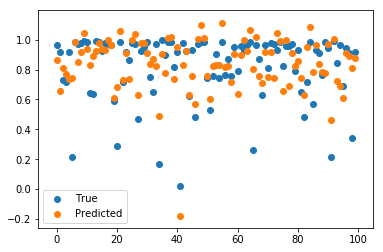

In [48]:
# Plot predictions and trye values
k = 100
xs = list(zip(sample["DRUG_ID"], sample["COSMIC_ID"]))
xs = np.arange(k)

plt.scatter(xs, y_true[:k], label="True")
plt.scatter(xs, predicted.numpy()[:k], label="Predicted")

plt.legend()
plt.show()

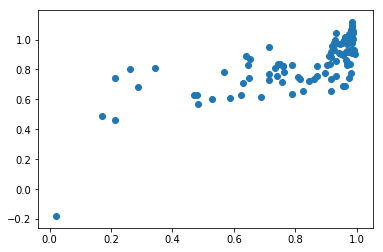

In [49]:
plt.scatter(y_true[:k], predicted.numpy()[:k])
plt.show()

#### Evaluation on separate cell lines

In [35]:
# Predict on validation data
sample = separate_cell_lines_samples
y_true = sample["AUC"].values

cl_input = cell_line_data.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted)

tensor(1.) tensor(4.1560e-39) tensor(0.0272)
RMSE: 0.867552398984234
Correlation: (-0.4057190958186736, 2.3022399936010215e-176)


## Prototype Model class

In [52]:
t = torch.tensor([2, -1, 3])

In [53]:
t

tensor([ 2, -1,  3])

In [54]:
F.relu(t)

tensor([2, 0, 3])